## Import libraries and read data

In [1]:
from pathlib import Path
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdFingerprintGenerator, rdMolDescriptors, AllChem, PandasTools
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles, MakeScaffoldGeneric

Load FDA approved drugs

In [2]:
# enable tqdm into pandas
tqdm.pandas()

HERE = Path(_dh[-1])
DATA_FOLDER = HERE.parent.parent/'data/fda_approved_datasets/'

fda_drugs = pd.read_csv(DATA_FOLDER/'fda_approved_drugs.csv')
fda_drugs.head(3)

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,natural_product_flag,oral,parenteral,topical
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,False,True,False,False
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,False,True,False,False
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,False,True,False,False


Proceeding to generate the Bemis-Murcko Scaffold. This approach is characterized for generating a chemical simplification of the structure, as Guy W. Bemis and Mark Murcko describe as 'frameworks'. The generation of such structures are ilustrated on the schematic representation below:

![Alt text](image.png)

## Bemis-Murcko Scaffold

In [3]:
fda_drugs['framework'] = fda_drugs.clean_smiles.progress_apply(MurckoScaffoldSmilesFromSmiles)

  0%|          | 0/1895 [00:00<?, ?it/s]

In [4]:
def make_generic_bm_mol(smiles):
    """
    Helper function to return the generic BM Scaffold in mol format of a given smiles.
    """
    return Chem.MolToSmiles(MakeScaffoldGeneric(Chem.MolFromSmiles(smiles)))

In [5]:
fda_drugs['generic_scaffold'] = fda_drugs.framework.progress_apply(make_generic_bm_mol)

  0%|          | 0/1895 [00:00<?, ?it/s]

In [6]:
scaffold_df = fda_drugs.generic_scaffold.value_counts().reset_index().copy() # cool trick
scaffold_df = scaffold_df[scaffold_df['generic_scaffold'] != ''].reset_index(drop=True).copy() # remove the error scaffolds

# Counting scaffoldings:
print(f"The first 30 frameworks accounts for {sum(scaffold_df['count'].to_list()[0:30])/sum(scaffold_df['count'].to_list())*100:.2f}% of frameworks present in the approved drugs.")
# Glimpse of the dat
scaffold_df

The first 30 frameworks accounts for 37.13% of frameworks present in the approved drugs.


,generic_scaffold,count
0,C1CCCCC1,200
1,CC1CCC2C(CCC3C4CCCC4CCC23)C1,81
2,C1CCC(CC2CCCCC2)CC1,52
3,C1CCC(C2CCCCC2)CC1,26
4,C1CCCC1,25
...,...,...
799,C1CCC(C(CCC2CCCC2)CC2CCCC2)CC1,1
800,C1CCC(CCC2CCC3CC(CC4CCCCC4)CCC23)CC1,1
801,CC1CCC2C(CCCCCC3CCCCC3)CCCC2C1,1
802,C1CCC(C2(CCCCC3CCCC3)CCCC3(CCCC3)C2)CC1,1


That is almost 40% of frameworks of the approved drugs have approximately only 30 different frameworks. That is questionable a poor framework diversity in the bidimensional shape of drugs.

In [7]:
# Converting the generic scaffolds to yield mol objects so we're able to draw them
scaffold_df['mol'] = scaffold_df.generic_scaffold.progress_apply(Chem.MolFromSmiles)

  0%|          | 0/804 [00:00<?, ?it/s]

In [8]:
# Drawing options
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.fixedFontSize = 22
IPythonConsole.drawOptions.legendFraction = 0.2
IPythonConsole.drawOptions.legendFontSize = 26

# Legends
legends = scaffold_df['count'].to_list()
legends = [f'n={x}' for x in legends]

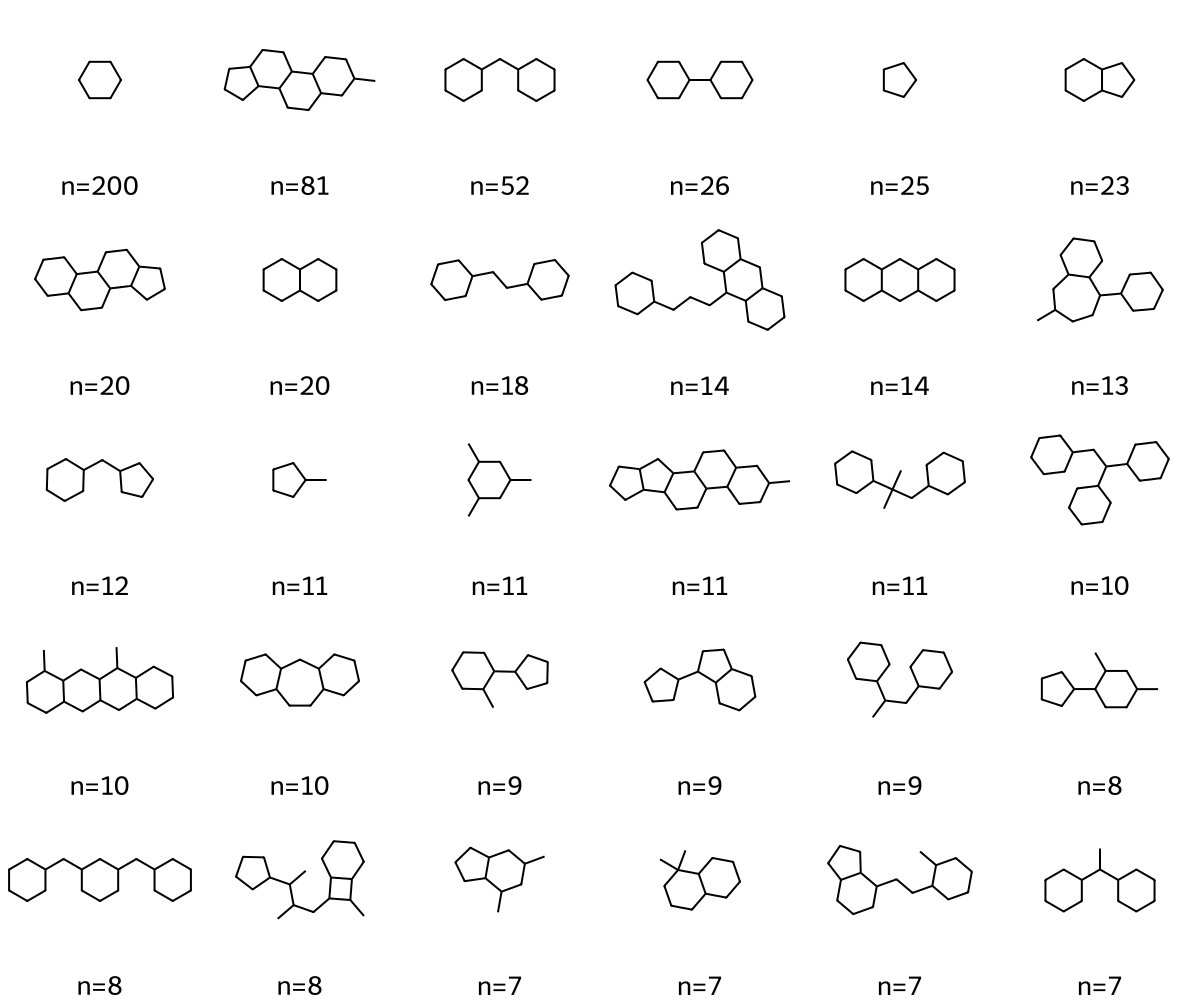

In [9]:
Draw.MolsToGridImage(
    mols =scaffold_df.mol[0:30],
    molsPerRow=6,
    legends=legends[0:30]
)

## Number of rings vs molecular weight throughout the years

Another interesting thing to investigate to finish the fingerprint chemical space approach of the approved drugs is to see if there is any relationship between the number of rings and the molecular weight increase through the years.

In [10]:
# Computing mol, number of rings and mw
fda_drugs['mol'] = fda_drugs.clean_smiles.apply(Chem.MolFromSmiles)
fda_drugs['nrings'] = fda_drugs.mol.apply(rdMolDescriptors.CalcNumRings)
fda_drugs['mw'] = fda_drugs.mol.apply(rdMolDescriptors.CalcExactMolWt)

# Glimpse of the data
fda_drugs[['chembl_id','clean_smiles','first_approval_year', 'nrings', 'mw']].head()

,chembl_id,clean_smiles,first_approval_year,nrings,mw
0,CHEMBL1200728,N=C(N)N,1939,0,59.048347
1,CHEMBL734,CC(=O)NO,1983,0,75.032028
2,CHEMBL467,NC(=O)NO,1967,0,76.027277
3,CHEMBL602,NCCS,1994,0,77.029920
4,CHEMBL504,C[S+](C)[O-],1978,0,78.013936


In [11]:
fda_drugs['first_approval_year'] = pd.to_numeric(fda_drugs['first_approval_year'], errors='coerce')
fda_drugs[fda_drugs['first_approval_year'] > 1983]

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,natural_product_flag,oral,parenteral,topical,framework,generic_scaffold,mol,nrings,mw
3,CYSTEAMINE,CHEMBL602,NCCS,1994.0,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,False,True,False,True,,,<rdkit.Chem.rdchem.Mol object at 0x7f601f158ee0>,0,77.029920
5,FOMEPIZOLE,CHEMBL1308,Cc1cn[nH]c1,1997.0,Antidote (alcohol dehydrogenase inhibitor),Small molecule,False,True,False,False,False,False,True,False,c1cn[nH]c1,C1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7f601f158fa0>,1,82.053098
7,LACTIC ACID,CHEMBL1200559,CC(O)C(=O)O,2006.0,NaN,Small molecule,False,True,False,False,False,False,True,False,,,<rdkit.Chem.rdchem.Mol object at 0x7f601f1680a0>,0,90.031694
8,DALFAMPRIDINE,CHEMBL284348,Nc1ccncc1,2010.0,Multiple Sclerosis Symptomatic Treatment,Small molecule,False,True,False,False,False,True,False,False,c1ccncc1,C1CCCCC1,<rdkit.Chem.rdchem.Mol object at 0x7f601f168100>,1,94.053098
10,OXYBATE,CHEMBL1342,O=C(O)CCCO,2002.0,SODIUM OXYBATE,Small molecule,False,True,False,False,False,True,False,False,,,<rdkit.Chem.rdchem.Mol object at 0x7f601f1681c0>,0,104.047344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,TENAPANOR,CHEMBL3304485,CN1Cc2c(Cl)cc(Cl)cc2[C@H](c2cccc(S(=O)(=O)NCCO...,2019.0,TENAPANOR HYDROCHLORIDE,Small molecule,False,True,False,False,False,True,False,False,O=C(NCCCCNC(=O)NCCOCCOCCNS(=O)(=O)c1cccc(C2CNC...,CC(CCCCCCCCCCC(C)(C)C1CCCC(C2CCCC3CCCCC32)C1)C...,<rdkit.Chem.rdchem.Mol object at 0x7f601d910be0>,6,1142.309743
1887,MICAFUNGIN,CHEMBL457547,CCCCCOc1ccc(-c2cc(-c3ccc(C(=O)N[C@H]4C[C@@H](O...,2005.0,MICAFUNGIN SODIUM,Small molecule,False,True,False,False,True,False,True,False,O=C(NC1CCCNC(=O)C2CCCN2C(=O)CNC(=O)C(CCc2ccccc...,CC(CC1CCCCC(C)C2CCCC2C(C)CCC(C)C(CCC2CCCCC2)CC...,<rdkit.Chem.rdchem.Mol object at 0x7f601d910ca0>,7,1269.438351
1888,SOMAPACITAN,CHEMBL3707290,C=C(CCCCCCCCCCCCCCCc1nnn[nH]1)NS(=O)(=O)CCCC(=...,2020.0,NaN,Small molecule,False,True,False,False,False,False,True,False,c1nnn[nH]1,C1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7f601d910d00>,1,1307.646510
1889,PAFOLACIANINE,CHEMBL4297412,CC1(C)C(/C=C/C2=C(Oc3ccc(C[C@H](NC(=O)c4ccc(NC...,2021.0,PAFOLACIANINE SODIUM,Small molecule,False,True,False,False,True,False,True,False,O=C(NCCc1ccc(OC2=C(C=CC3=[NH+]c4ccccc4C3)CCCC2...,CC(CCCC1CCC(CC2C(CCC3CC4CCCCC4C3)CCCC2CCC2CC3C...,<rdkit.Chem.rdchem.Mol object at 0x7f601d910d60>,9,1326.361052


### Plot  #rings through the years

In [64]:
fda_drugs_subplot = fda_drugs[(fda_drugs['first_approval_year'] >= 1960) & (fda_drugs['first_approval_year'] < 9999) ]
fda_drugs_subplot = fda_drugs_subplot[['mw', 'first_approval_year', 'nrings']].sort_values(by=['first_approval_year'])
fda_drugs_subplot['first_approval_year'] = fda_drugs_subplot.first_approval_year.astype(int)
fda_drugs_subplot

,mw,first_approval_year,nrings
1450,452.246378,1960,4
1103,378.902181,1960,2
404,256.113078,1960,0
481,273.022642,1960,2
1760,608.273381,1960,6
...,...,...,...
1339,425.200317,2022,4
1324,422.181487,2022,4
1306,418.175339,2022,4
864,332.271530,2022,4


Text(0, 0.5, 'Number of rings')

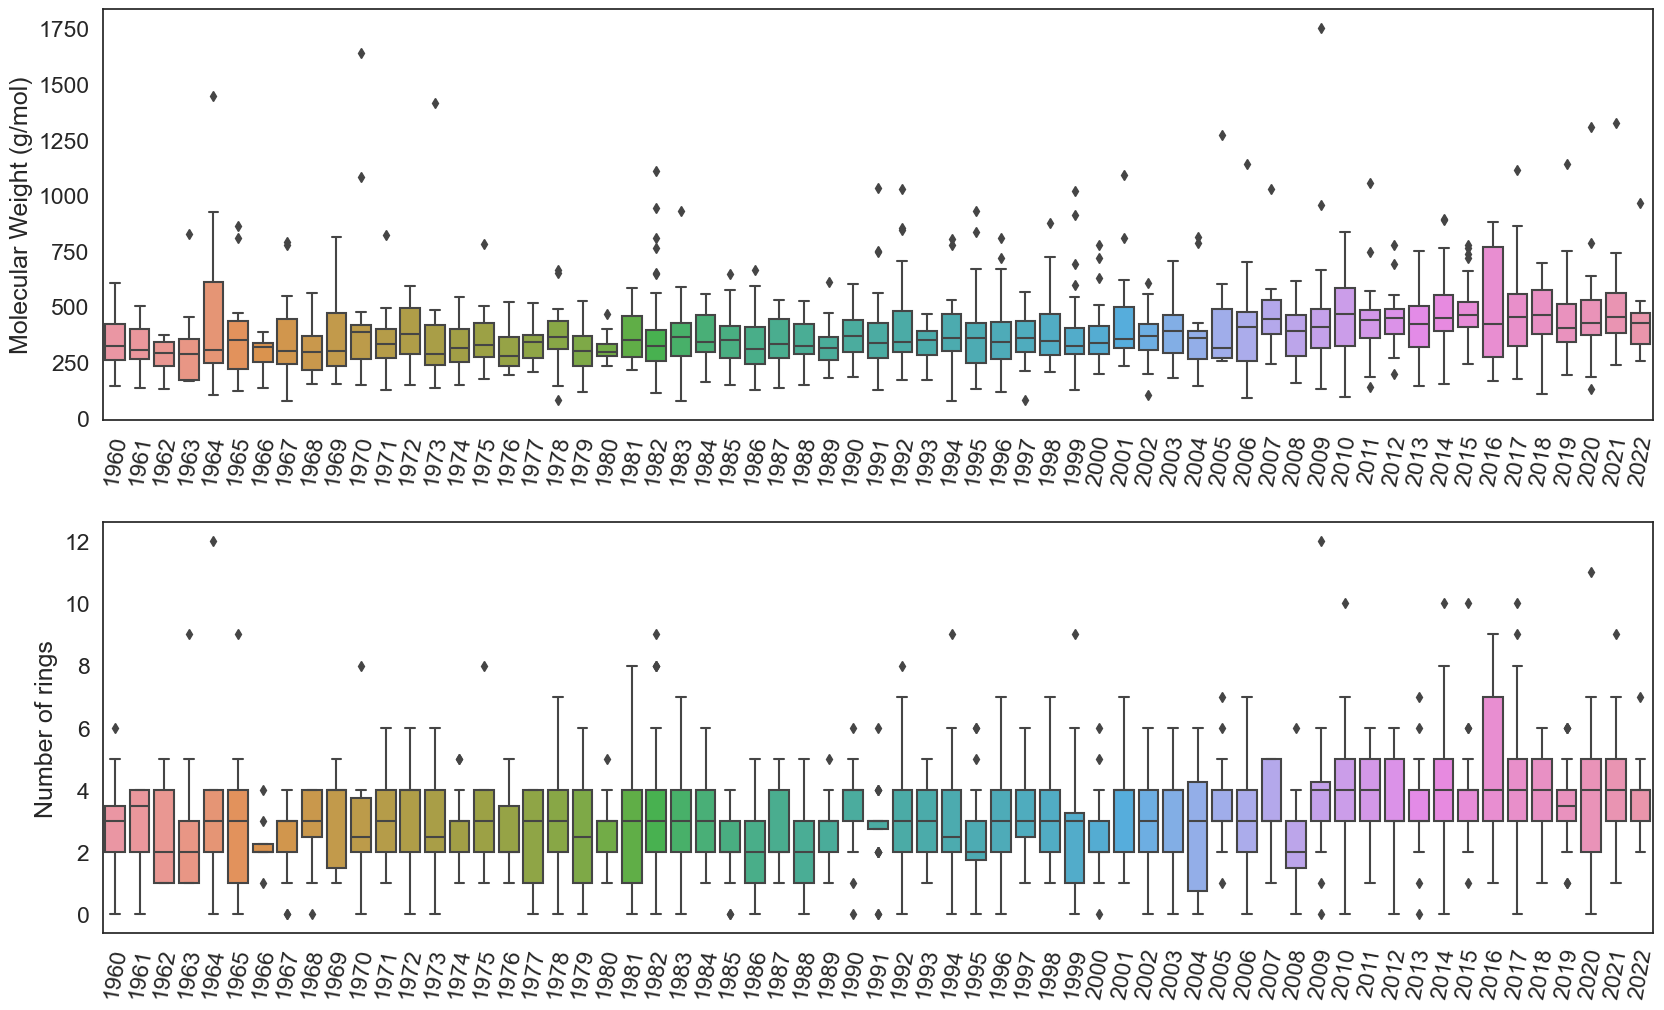

In [83]:
sns.set_theme(style='white', palette='viridis', font_scale=1.5)
fig, axs = plt.subplots(2,1, figsize=(20, 12))
plt.subplots_adjust(hspace=0.25)

sns.boxplot(data=fda_drugs_subplot, y='mw', x='first_approval_year', ax=axs[0])
axs[0].set_xlabel('')
axs[0].set_ylabel('Molecular Weight (g/mol)')
axs[0].tick_params(axis='x',labelrotation=80)

sns.boxplot(data=fda_drugs_subplot, y='nrings', x='first_approval_year', ax=axs[1])
axs[1].set_xlabel('')
axs[1].tick_params(axis='x',labelrotation=80)
axs[1].set_ylabel('Number of rings')

# fig.suptitle('Distribution of Molecular Weight and Number of Rings of FDA approved drugs throughout the years', fontsize=22)


<Axes: xlabel='first_approval_year', ylabel='mw'>

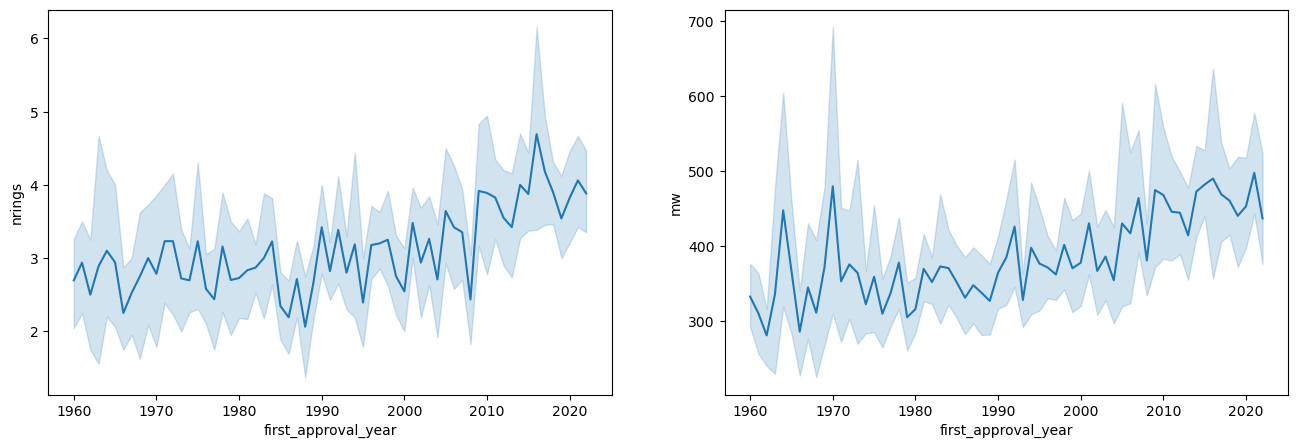

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
sns.lineplot(x='first_approval_year', y='nrings', data=fda_drugs_subplot, ax=axs[0])
sns.lineplot(x='first_approval_year', y='mw', data=fda_drugs_subplot, ax=axs[1])

In [30]:
from scipy.stats import kendalltau
kendalltau(fda_drugs_subplot['mw'], fda_drugs_subplot['nrings'])

SignificanceResult(statistic=0.5450518185243044, pvalue=2.10413692094823e-177)

Conclusion: The approved drugs are growing in molecular weight at the same time as they are growing in number of rings i.e., the growing change in molecular mass throughout the years, a phenomenon coined as `'molecular obesity'` is accompained by an increase in the number of rings in the structure. The structures are not growing `aliphatically`.